# MGTA 634 Group Case Code

## Sarah Mansoor, Mengxi Dai, Yiyang Zhang, Hai Ninh Vu

## July 27, 2023

Table of contents
* Busines problem
* Data Exploration and Preprocessing
* CLV Analysis
* Recency, Frequency, Monetary (RFM) Analysis
* Marketing Basket Analysis (MBA)
* Promotion Recommendation
* Dimensionality Reduction
* Clustering

# Business Problem

### Business Problem:
- Shine Inc., a medium-size cosmetics company, is facing slowed growth and increased competition in the online cosmetic sector. They need to find a way to increase profit margins and improve operational efficiency in order to stay competitive in the market.

### Potential Approaches:

- **1:** Targeting Customers: Shine can focus on a young demographic cohort and offer personalized coupons to incentivize repeat purchases. 
- **2:** Alternatively, they can target new customers and offer deeper discounts to attract them to the brand.
- **3:** Focusing on Merchandise: Shine can select specific items or bundles and heavily promote them to make them more appealing to customers.

# Data Exploration and Preprocessing:

- Start by exploring and understanding the dataset, checking for missing values, outliers, and data inconsistencies.
- Preprocess the data by cleaning and transforming it into a suitable format for analysis. This may include converting categorical variables into numerical representations (e.g., one-hot encoding), normalizing numeric variables, and handling missing values.

In [4]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, association_rules
from surprise import accuracy, Dataset, Reader, SVD, SVDpp, CoClustering, KNNBasic
from surprise.model_selection import cross_validate, GridSearchCV

### Read and preprocess the transaction and product data

In [5]:
# Read the XLSX file
df = pd.read_excel('Shine.Case.Data_2022S.xlsx')
df_sku = pd.read_excel('SKU_list.xlsx')

# Assign unique transaction IDs
df.insert(0, 'transaction_id', pd.Series(np.arange(1, len(df) + 1)))

# Merge the datasets based on the SKU column
df = pd.merge(df, df_sku, on='sku', how='left')

# Convert the discount column to numeric values
df['discount'] = pd.to_numeric(df['discount'].str.rstrip('%'), errors='coerce') / 100

# Create the 'actual_price' column
df['actual_price'] = df['price'] * (1 - df['discount'])
df['actual_price'] = df['actual_price'].round(2)

# Create "profit" column
df['profit'] = df['actual_price']-df['Cost']
df['profit'] = df['profit'].round(2)

# Create "total_profit" column - some transaction with quantity > 1
df['total_profit'] = df['quantity']*df['profit']

# Create "spend" column - some transaction with quantity > 1
df['spend'] = df['quantity']*df['price']

In [6]:
df

,transaction_id,id,transaction.date,sku,price,discount,quantity,age,gender,tenure,return,Retail price,Cost,actual_price,profit,total_profit,spend
0,1,110010,2017-03-15,FCS48024,59.99,0.00,1,22,F,2,0,59.99,34,59.99,25.99,25.99,59.99
1,2,110010,2017-04-04,FCS48026,56.99,0.00,1,22,F,2,0,56.99,35,56.99,21.99,21.99,56.99
2,3,110010,2017-05-11,FCS48029,44.99,0.10,2,22,F,2,0,44.99,20,40.49,20.49,40.98,89.98
3,4,110010,2017-06-03,SCS72049,79.99,0.25,1,22,F,2,0,79.99,48,59.99,11.99,11.99,79.99
4,5,110010,2017-06-05,FCS48028,69.99,0.00,1,22,F,2,0,69.99,42,69.99,27.99,27.99,69.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46260,46261,189920,2017-03-02,SCS72048,69.99,0.10,1,26,Other,5,0,69.99,42,62.99,20.99,20.99,69.99
46261,46262,189920,2017-05-24,FCS48031,38.99,0.00,1,26,Other,5,0,38.99,25,38.99,13.99,13.99,38.99
46262,46263,189920,2017-05-24,SCS72042,44.99,0.15,2,26,Other,5,0,44.99,32,38.24,6.24,12.48,89.98
46263,46264,189920,2017-05-24,FCS48020,79.99,0.25,1,26,Other,5,0,79.99,48,59.99,11.99,11.99,79.99


### Aggregate transaction data to get customer level data

In [7]:
# Create the customer dataframe
df_customer = df[['id', 'age', 'gender', 'tenure']].drop_duplicates()

# check the customer dataframe
print ("shape of df_customer:", df_customer.shape)
print ('Number of unique ID:', df_customer['id'].nunique())

shape of df_customer: (4827, 4)
Number of unique ID: 4679


Mismatch in number of rows in df_customer and unique customer ID. I checked Exhibit D in pdf case file, the right number of customers is 4827. Therefore, we keep all rows but need to groups transaction data not only by 'id' but all ['id', 'age', 'gender', 'tenure']

In [8]:
# Calculate average price and discount
average_price_discount = df.groupby(['id', 'age', 'gender', 'tenure'])['price', 'discount'].mean().reset_index()

# Calculate total quantity, total return, total profit and date of last order
aggregated_data = df.groupby(['id', 'age', 'gender', 'tenure']).agg({
    'quantity': 'sum',
    'return': 'sum',
    'total_profit': 'sum',
    'spend': 'sum',
    'transaction.date': 'max'
}).reset_index()

# Create variables indicating the number of each SKUs the "id" bought
sku_counts = df.groupby(['id', 'age', 'gender', 'tenure', 'sku'])['quantity'].sum().unstack(fill_value=0).reset_index()

# Merge all the aggregated data
df_customer = pd.merge(average_price_discount, aggregated_data, on=['id', 'age', 'gender', 'tenure'])

# Rename columns for clarity (optional)
df_customer = df_customer.rename(columns={'price': 'average_price', 'discount': 'average_discount', 
                                          'quantity': 'total_quantity','return': 'total_return',
                                          'spend': 'total_spend', 'transaction.date': 'last_order_date'})

# Calculate number of orders
aggregated_data = df.groupby(['id', 'age', 'gender', 'tenure']).agg({'transaction.date': 'nunique'}).reset_index()

df_customer = pd.merge(df_customer, aggregated_data, on=['id', 'age', 'gender', 'tenure'])
df_customer = df_customer.rename(columns={'transaction.date': 'number_order'})
df_customer = pd.merge(df_customer, sku_counts, on=['id', 'age', 'gender', 'tenure'])

# because the ids are not unique for customers, I assign new customer_ID ranging from 1 to 4827 to make it easier 
# in futher analysis
df_customer['customer_id'] = range(1,4828)
df_customer = df_customer[['customer_id'] + list(df_customer.columns[:-1])]
df_customer['average_price'] = df_customer['total_spend']/df_customer['total_quantity']

# Print the result
df_customer.iloc[:10,:15]

D:\Anaconda\envs\rstudio\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,customer_id,id,age,gender,tenure,average_price,average_discount,total_quantity,total_return,total_profit,total_spend,last_order_date,number_order,FCS48020,FCS48021
0,1,110010,22,F,2,61.906667,0.050000,12,0,273.98,742.88,2017-06-19,8,0,1
1,2,110039,34,F,10,70.740000,0.062500,8,0,198.52,565.92,2017-06-03,8,0,1
2,3,110114,27,F,0,60.212222,0.118750,9,1,159.91,541.91,2017-05-30,7,0,0
3,4,110125,26,F,0,55.656667,0.144444,9,0,129.16,500.91,2017-05-22,7,0,1
4,5,110127,23,F,0,59.890000,0.045000,10,0,216.45,598.90,2017-06-23,9,0,1
5,6,110152,27,F,1,64.808182,0.172727,11,1,145.64,712.89,2017-05-11,7,1,1
6,7,110153,28,F,0,62.990000,0.014286,7,0,177.23,440.93,2017-04-15,5,0,1
7,8,110220,32,F,7,72.156667,0.062500,12,1,268.88,865.88,2017-07-19,9,0,1
8,9,110232,25,F,0,56.740000,0.043750,8,0,168.92,453.92,2017-06-12,7,0,1
9,10,110256,29,F,2,65.790000,0.110000,5,0,102.10,328.95,2017-06-05,4,0,0


### Visualize customer data
- From the histogram, the typical profit from each customer is around \\$200, with the majority of profits falling within the range of \\$100 to \\$300.


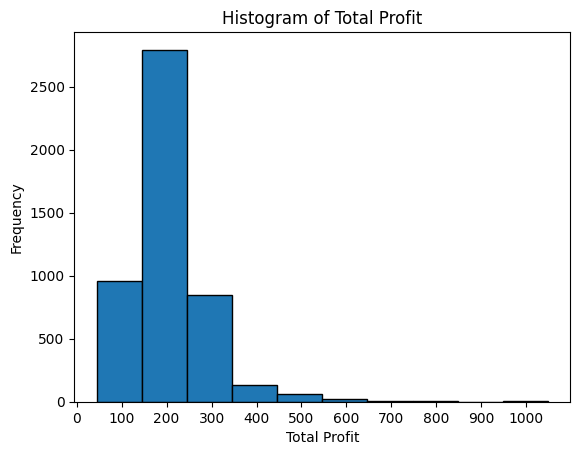

In [9]:
# Plot histogram for 'total_profit' column
plt.hist(df_customer['total_profit'], bins=10, edgecolor='black')

# Set labels and title
plt.xlabel('Total Profit')
plt.ylabel('Frequency')
plt.title('Histogram of Total Profit')

# Customize x-axis labels to show every 100 values
plt.xticks(range(0, df_customer['total_profit'].astype(int).max()+1, 100))

# Show the plot
plt.show()

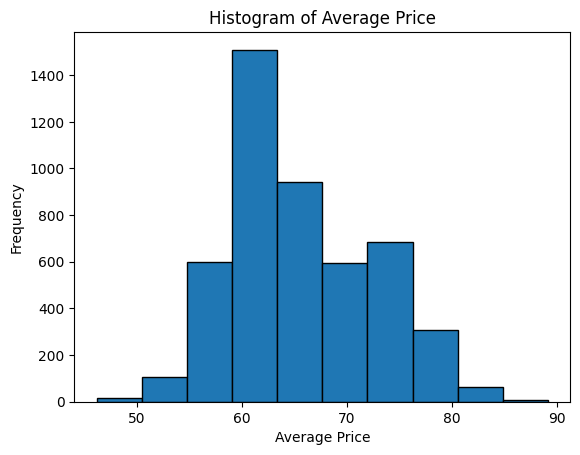

In [10]:
# Plot histogram for 'average_price' column
plt.hist(df_customer['average_price'], bins=10, edgecolor='black')

# Set labels and title
plt.xlabel('Average Price')
plt.ylabel('Frequency')
plt.title('Histogram of Average Price')

# Show the plot
plt.show()

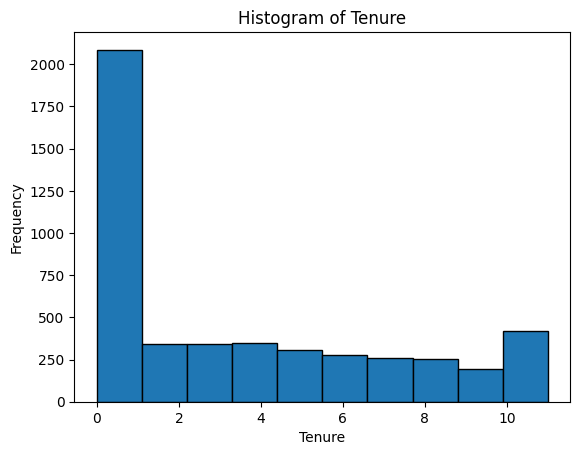

In [11]:
# Plot histogram for 'tenure' column
plt.hist(df_customer['tenure'], bins=10, edgecolor='black')

# Set labels and title
plt.xlabel('Tenure')
plt.ylabel('Frequency')
plt.title('Histogram of Tenure')

plt.show()

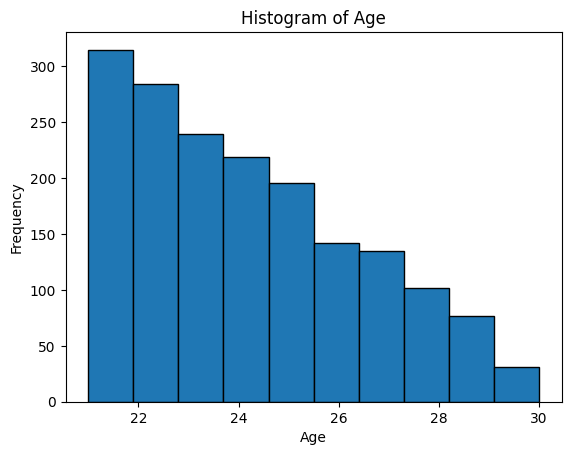

In [12]:
# Plot histogram for 'age' column
plt.hist(df_customer[df_customer['tenure']==0]['age'], bins=10, edgecolor='black')

# Set labels and title
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of Age')

plt.show()

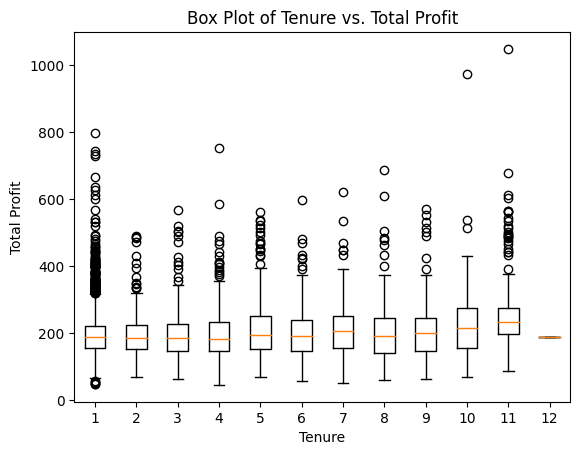

In [13]:
# Create box plot
plt.boxplot(df_customer.groupby('tenure')['total_profit'].apply(list))

# Set labels and title
plt.xlabel('Tenure')
plt.ylabel('Total Profit')
plt.title('Box Plot of Tenure vs. Total Profit')

# Show the plot
plt.show()


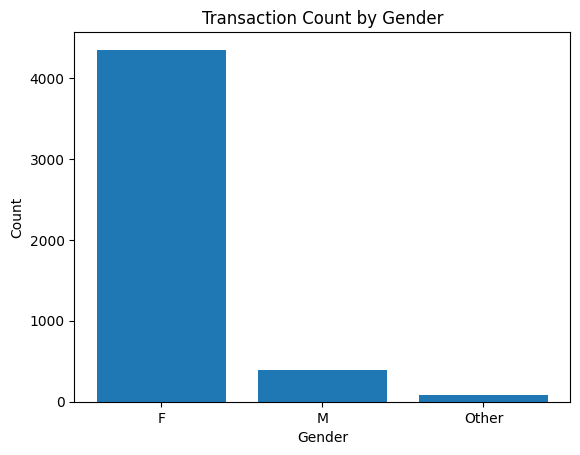

In [14]:
import matplotlib.pyplot as plt

gender_counts = df_customer['gender'].value_counts()
plt.bar(gender_counts.index, gender_counts.values)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Transaction Count by Gender')
plt.show()

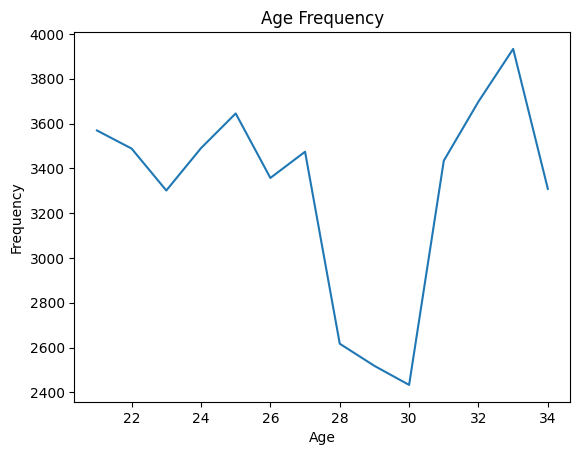

In [15]:
import matplotlib.pyplot as plt

# Calculate the frequency of each age value
age_frequency = df['age'].value_counts().sort_index()

# Create the line plot
plt.plot(age_frequency.index, age_frequency.values)

# Set the labels and title
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Frequency')

# Display the plot
plt.show()

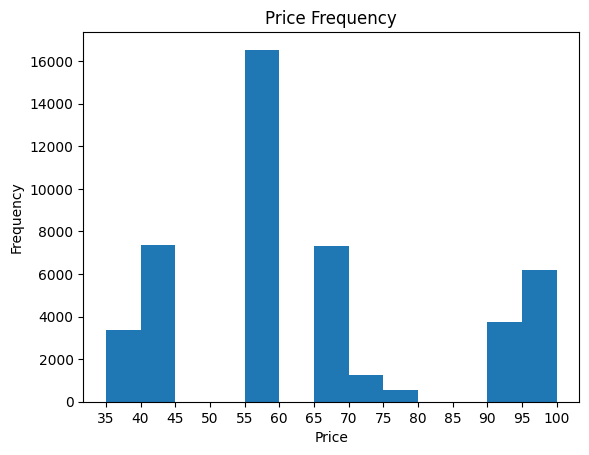

In [16]:
import matplotlib.pyplot as plt

# Define the custom bin edges
bin_edges = range(35, 101, 5)

# Create the frequency plot with custom bins
plt.hist(df['price'], bins=bin_edges)

# Set the labels and title
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Price Frequency')

# Set x-axis tick locations and labels
plt.xticks(range(35, 101, 5))

# Display the plot
plt.show()


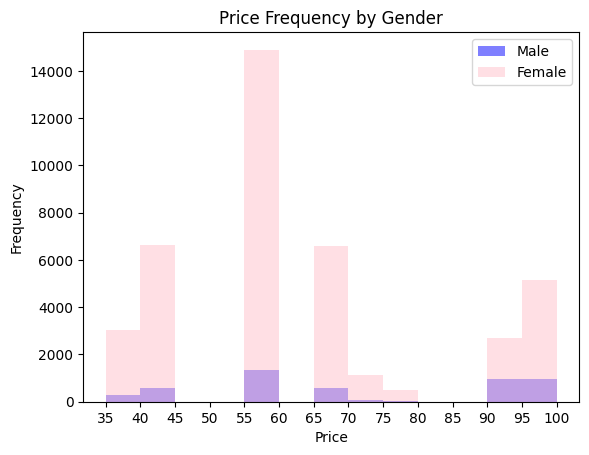

In [17]:
import matplotlib.pyplot as plt

# Define the custom bin edges
bin_edges = range(35, 101, 5)

# Create separate histograms for each gender
plt.hist(df[df['gender'] == 'M']['price'], bins=bin_edges, color='blue', alpha=0.5, label='Male')
plt.hist(df[df['gender'] == 'F']['price'], bins=bin_edges, color='pink', alpha=0.5, label='Female')

# Set the labels and title
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Price Frequency by Gender')

# Set x-axis tick locations and labels
plt.xticks(range(35, 101, 5))

# Add a legend
plt.legend()

# Display the plot
plt.show()

### Aggregate transaction data by SKU to get product data

In [18]:
# Group by SKU and calculate the required product information
product_info = df.groupby('sku').agg({
    'transaction_id': 'count',          # Number (count) of transactions
    'quantity': 'sum',                  # Total sales as sum of quantity
    'discount': ['mean', lambda x: (x > 0).sum()],  # Average discount and Number (count) of discounts
    'return': 'sum',                    # Total return
    'actual_price': 'mean',             # Average actual_price
    'profit': 'mean',                   # Average profit
    'total_profit': 'sum'               # Total profit
})

# Flatten the multi-level column index
product_info.columns = ['_'.join(col) for col in product_info.columns]

# Rename columns for clarity (optional)
product_info = product_info.rename(columns={
    'transaction_id_count': 'trans_count',
    'quantity_sum': 'total_sales',
    'discount_mean': 'average_discount',
    'discount_<lambda_0>': 'trans_count_with_discount',
    'return_sum': 'total_returns',
    'actual_price_mean': 'average_actual_price',
    'profit_mean': 'average_profit',
    'total_profit_sum': 'total_profit'
})

df_sku = df_sku.merge(product_info, on='sku')

df_sku['margin'] = df_sku.iloc[:,1]-df_sku['Cost']

# Print the product information
df_sku

,sku,Retail price,Cost,trans_count,total_sales,average_discount,trans_count_with_discount,total_returns,average_actual_price,average_profit,total_profit,margin
0,FCS48020,79.99,48,267,352,0.273783,267,13,58.087378,10.087378,3504.48,31.99
1,FCS48021,56.99,34,3769,4127,0.084890,1581,217,52.151276,18.151276,72074.03,22.99
2,FCS48022,94.99,60,1242,1336,0.084098,510,79,87.000668,27.000668,34781.39,34.99
3,FCS48023,99.99,65,1209,1326,0.089123,532,75,91.077676,26.077676,32991.74,34.99
4,FCS48024,59.99,34,1686,1858,0.090421,744,68,54.564733,20.564733,36724.42,25.99
5,FCS48025,74.99,45,384,492,0.248568,384,25,56.347422,11.347422,5545.08,29.99
6,FCS48026,56.99,35,1651,1783,0.078619,646,98,52.508716,17.508716,30162.27,21.99
7,FCS48027,94.99,57,1238,1384,0.089701,544,65,86.468393,29.468393,38717.66,37.99
8,FCS48028,69.99,42,3369,3672,0.082012,1384,212,64.249127,22.249127,78702.78,27.99
9,FCS48029,44.99,20,4000,4364,0.083838,1671,228,41.217312,21.217312,90271.11,24.99


In [19]:
df_sku['total_returns']/df_sku['total_sales']*100

0     3.693182
1     5.258057
2     5.913174
3     5.656109
4     3.659849
5     5.081301
6     5.496354
7     4.696532
8     5.773420
9     5.224565
10    4.528302
11    5.591926
12    5.054945
13    4.664723
14    5.049088
15    5.482815
16    4.931571
17    4.921912
18    5.080831
19    5.608388
20    5.243446
21    5.643402
22    4.800000
dtype: float64

# CLV analysis
Currently, we do not have information about churn rate of our customers. Therefore, considering high churn rate of the industry, I assume that the churn rate is at 50%/year, the average life span is 02 years (the median of tenure from our dataset) and discount rate for future cash flow is 10%.

Our data is from first half of the year 2017. I will annualize the cohort data (purchase_quantity, returns, spending, profit and number of order).

- Profit from sales = Reveune - cost of goods
- Return cost = 21 per return
- Order processing cost = 5 per order
- Acquisition cost: 94 (I assume it keep increasing 6 dollars as two last years)

M = Profit from Sales - Return Cost - Order Cost

CLV = M + M*(1-0.5)/(1+0.1) - AC

=> The cohort 5 with age ranging from 32 to 34 has highest CLV of 469. For new customer acquisition campaign, we should first target on 32-34 years old customer.

In [20]:
# sort customers by age
df_clv = df_customer.iloc[:,2:13].sort_values(by='age', ascending=True)

# create cohort column
df_clv['cohort_group'] = 1
df_clv['cohort_group'][966:1932] = 2
df_clv['cohort_group'][1932:2897] = 3
df_clv['cohort_group'][2897:3862] = 4
df_clv['cohort_group'][3862:] = 5

# group by to get cohort level data
df_clv = df_clv.groupby('cohort_group').agg({
    'average_price': 'mean',
    'average_discount': 'mean',
    'total_quantity': 'mean',
    'total_return':'mean',
    'total_spend': 'mean',
    'total_profit': 'mean',
    'number_order': 'mean'
})

# annualize the cohort data (purchase_quantity, returns, spending, profit and number of order)
df_clv['total_quantity'] = df_clv['total_quantity']*2
df_clv['total_return'] = df_clv['total_return']*2
df_clv['total_spend'] = df_clv['total_spend']*2
df_clv['total_profit'] = df_clv['total_profit']*2
df_clv['number_order'] = df_clv['number_order']*2

# rename columns
df_clv = df_clv.rename (columns={
    'total_quantity': 'purchased_quantity',
    'total_return': 'product_return',
    'total_spend': 'spend',
    'total_profit': 'profit'
})

D:\Anaconda\envs\rstudio\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\Anaconda\envs\rstudio\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
D:\Anaconda\envs\rstudio\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\Anaconda\envs\rstudio\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyW

In [21]:
# compute CLV
df_clv['CLV'] = (df_clv['profit'] - 5*df_clv['number_order'] - 21*df_clv['product_return']) + (df_clv['profit'] - 5*df_clv['number_order'] - 21*df_clv['product_return'])*(1-0.5)/(1+0.1) - 94

In [22]:
df_clv

,average_price,average_discount,purchased_quantity,product_return,spend,profit,number_order,CLV
cohort_group,,,,,,,,
1,62.612248,0.098126,22.428571,1.194617,1411.883375,409.263188,16.169772,347.203448
2,62.998078,0.098139,22.784679,1.186335,1446.618944,418.354555,16.525880,358.090344
3,62.274332,0.090217,18.837306,1.036269,1182.893492,351.447275,13.262176,289.090525
4,66.592105,0.082701,18.424870,0.853886,1251.832332,379.820518,13.127461,336.911427
5,73.386582,0.084275,22.974093,1.255959,1686.431399,497.974197,16.918135,468.921300


# RFM analysis

In [23]:
# Create new df_rfm dataframe
df_rfm = df_customer [['customer_id','id','age','gender','tenure','last_order_date','number_order','total_spend']]
df_rfm['day_from_last_order'] = df_rfm['last_order_date'].max() - df_rfm['last_order_date'] 

# set number of bins
num_bins = 2

# compute recency score
# Sort the DataFrame based on 'day_from_last_order' in ascending order
df_rfm = df_rfm.sort_values(by='day_from_last_order', ascending=True)
# Create a list to store the recency scores
scores = []
# Assign recency scores to each observation
for i in range(len(df_rfm)):
    score = num_bins - (i // (len(df_rfm)//num_bins))
    if score == 0: score = 1
    scores.append(score)
# Add the 'recency_score' column to the DataFrame
df_rfm['recency_score'] = scores

# compute frequency score
# Sort the DataFrame based on 'day_from_last_order' in descending order
df_rfm = df_rfm.sort_values(by='number_order', ascending=False)
# Create a list to store the recency scores
scores = []
# Assign frequency scores to each observation
for i in range(len(df_rfm)):
    score = num_bins - (i // (len(df_rfm)//num_bins))
    if score == 0: score = 1
    scores.append(score)
# Add the 'frequency_score' column to the DataFrame
df_rfm['frequency_score'] = scores

# compute monetary score
# Sort the DataFrame based on 'total_spend' in descending order
df_rfm = df_rfm.sort_values(by='total_spend', ascending=False)
# Create a list to store the recency scores
scores = []
# Assign monetary scores to each observation
for i in range(len(df_rfm)):
    score = num_bins - (i // (len(df_rfm)//num_bins))
    if score == 0: score = 1
    scores.append(score)
# Add the 'monetary_score' column to the DataFrame
df_rfm['monetary_score'] = scores

df_rfm['rfm_score'] = df_rfm['recency_score']*100 + df_rfm['frequency_score']*10 + df_rfm['monetary_score'] 

df_rfm

D:\Anaconda\envs\rstudio\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,customer_id,id,age,gender,tenure,last_order_date,number_order,total_spend,day_from_last_order,recency_score,frequency_score,monetary_score,rfm_score
1167,1168,129442,33,F,10,2017-07-20,32,3303.55,0 days,2,2,2,222
4410,4411,182944,25,M,3,2017-07-08,31,2844.59,12 days,2,2,2,222
607,608,119839,33,F,9,2017-07-05,31,2825.61,15 days,2,2,2,222
4450,4451,183631,24,M,0,2017-07-20,28,2798.62,0 days,2,2,2,222
3195,3196,163149,21,F,0,2017-07-08,29,2778.56,12 days,2,2,2,222
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3553,3554,168837,30,F,5,2017-03-20,3,186.97,122 days,1,1,1,111
1721,1722,138956,28,F,6,2017-03-11,3,186.97,131 days,1,1,1,111
280,281,114822,28,F,0,2017-05-08,3,186.97,73 days,1,1,1,111
4778,4779,189125,28,Other,3,2017-05-17,3,165.97,64 days,1,1,1,111


In [24]:
df_rfm[df_rfm['recency_score']==1]['day_from_last_order'].min()

Timedelta('17 days 00:00:00')

In [25]:
df_rfm['rfm_score'].value_counts()

111    1159
222    1157
122     805
211     804
212     231
121     230
221     221
112     220
Name: rfm_score, dtype: int64

# Marketing Basket Analysis (MBA)
### MBA for customer data

In [26]:
print (df_customer.columns[13:])

Index(['FCS48020', 'FCS48021', 'FCS48022', 'FCS48023', 'FCS48024', 'FCS48025',
       'FCS48026', 'FCS48027', 'FCS48028', 'FCS48029', 'FCS48030', 'FCS48031',
       'FCS48032', 'FCS48033', 'SCS72041', 'SCS72042', 'SCS72043', 'SCS72044',
       'SCS72045', 'SCS72046', 'SCS72047', 'SCS72048', 'SCS72049'],
      dtype='object')


In [27]:
from mlxtend.frequent_patterns import apriori, association_rules

# Select only the SKU columns from the df_customer dataframe
sku_columns = df_customer.columns[13:]  # Adjust the column range based on your data

# Convert SKU columns to boolean (True if bought, False if not)
df_mba = df_customer[sku_columns].apply(lambda x: (x > 0))

# Apply Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(df_mba, min_support=0.5, use_colnames=True)

# Generate association rules based on the frequent itemsets
customer_rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1)

# Sort the rules by descending lift
customer_rules = customer_rules.sort_values(by='lift', ascending=False)

# Print the top 10 association rules
customer_rules.head(10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
29,(SCS72048),(SCS72044),0.662938,0.762793,0.513984,0.775313,1.016413,0.008300,1.055721,0.047909
28,(SCS72044),(SCS72048),0.762793,0.662938,0.513984,0.673819,1.016413,0.008300,1.033359,0.068076
9,(FCS48028),(SCS72043),0.664802,0.761757,0.513570,0.772515,1.014123,0.007152,1.047291,0.041546
8,(SCS72043),(FCS48028),0.761757,0.664802,0.513570,0.674191,1.014123,0.007152,1.028817,0.058453
25,(SCS72042),(SCS72044),0.663352,0.762793,0.512948,0.773267,1.013731,0.006948,1.046196,0.040236
24,(SCS72044),(SCS72042),0.762793,0.663352,0.512948,0.672461,1.013731,0.006948,1.027809,0.057103
23,(FCS48031),(SCS72044),0.663766,0.762793,0.511291,0.770287,1.009825,0.004975,1.032626,0.028937
22,(SCS72044),(FCS48031),0.762793,0.663766,0.511291,0.670288,1.009825,0.004975,1.019780,0.041017
14,(SCS72043),(FCS48029),0.761757,0.786203,0.602652,0.791134,1.006273,0.003757,1.023611,0.026164
15,(FCS48029),(SCS72043),0.786203,0.761757,0.602652,0.766535,1.006273,0.003757,1.020466,0.029156


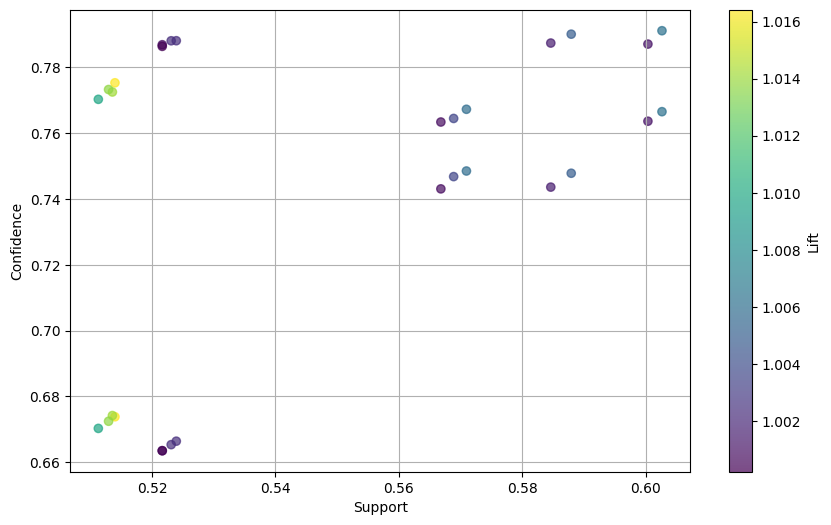

In [28]:
# Plot the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(customer_rules['support'], customer_rules['confidence'], c=customer_rules['lift'], cmap='viridis', alpha=0.7)

# Add labels and colorbar
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.colorbar(label='Lift')

# Add grid lines
plt.grid(True)

# Show the plot
plt.show()

In [29]:
customer_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
29,(SCS72048),(SCS72044),0.662938,0.762793,0.513984,0.775313,1.016413,0.008300,1.055721,0.047909
28,(SCS72044),(SCS72048),0.762793,0.662938,0.513984,0.673819,1.016413,0.008300,1.033359,0.068076
9,(FCS48028),(SCS72043),0.664802,0.761757,0.513570,0.772515,1.014123,0.007152,1.047291,0.041546
8,(SCS72043),(FCS48028),0.761757,0.664802,0.513570,0.674191,1.014123,0.007152,1.028817,0.058453
25,(SCS72042),(SCS72044),0.663352,0.762793,0.512948,0.773267,1.013731,0.006948,1.046196,0.040236
24,(SCS72044),(SCS72042),0.762793,0.663352,0.512948,0.672461,1.013731,0.006948,1.027809,0.057103
23,(FCS48031),(SCS72044),0.663766,0.762793,0.511291,0.770287,1.009825,0.004975,1.032626,0.028937
22,(SCS72044),(FCS48031),0.762793,0.663766,0.511291,0.670288,1.009825,0.004975,1.019780,0.041017
14,(SCS72043),(FCS48029),0.761757,0.786203,0.602652,0.791134,1.006273,0.003757,1.023611,0.026164
15,(FCS48029),(SCS72043),0.786203,0.761757,0.602652,0.766535,1.006273,0.003757,1.020466,0.029156


### MBA for order data

In [30]:
# Create order dataframe, each row representing for a order, columns are SKU dummy variables
df_mba = df.pivot_table(index=['id', 'transaction.date'], columns='sku', values='quantity', fill_value=0)
df_mba = df_mba.apply(lambda x: (x > 0))

# Apply Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(df_mba, min_support=0.01, use_colnames=True)

# Generate association rules based on the frequent itemsets
order_rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1)

# Sort the rules by descending lift
order_rules = order_rules.sort_values(by='lift', ascending=False)

# Print the top 10 association rules
order_rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
2,(SCS72048),(FCS48028),0.089599,0.093459,0.058492,0.652821,6.985086,0.050118,2.611161,0.941165
3,(FCS48028),(SCS72048),0.093459,0.089599,0.058492,0.625854,6.985086,0.050118,2.433281,0.945173
6,(SCS72044),(SCS72043),0.103347,0.107513,0.070407,0.681268,6.336624,0.059296,2.800122,0.939256
7,(SCS72043),(SCS72044),0.107513,0.103347,0.070407,0.654870,6.336624,0.059296,2.598013,0.943641
5,(FCS48031),(SCS72042),0.093320,0.089654,0.049021,0.525298,5.859151,0.040654,1.917719,0.914686
4,(SCS72042),(FCS48031),0.089654,0.093320,0.049021,0.546778,5.859151,0.040654,2.000521,0.911002
0,(FCS48021),(SCS72046),0.104597,0.100680,0.061214,0.585236,5.812809,0.050683,2.168270,0.924685
1,(SCS72046),(FCS48021),0.100680,0.104597,0.061214,0.608000,5.812809,0.050683,2.284192,0.920658


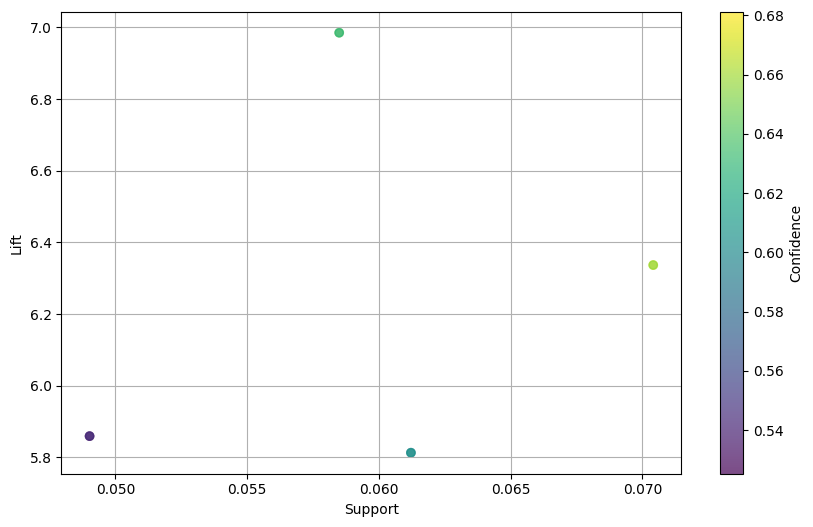

In [31]:
# Plot the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(order_rules['support'], order_rules['lift'], c=order_rules['confidence'], cmap='viridis', alpha=0.7)

# Add labels and colorbar
plt.xlabel('Support')
plt.ylabel('Lift')
plt.colorbar(label='Confidence')

# Add grid lines
plt.grid(True)

# Show the plot
plt.show()

In [32]:
bundles = pd.DataFrame ({'bundle':['SCS72048 + FCS48028', 'SCS72043 + SCS72044', 'FCS48031 + SCS72042', 'SCS72046 + FCS48021'],
                        'retail_price':[139.98,119.98,83.98,156.98],
                        'cost':[84,70,57,94]})

bundles['margin'] = bundles['retail_price'] - bundles['cost']

bundles = bundles.iloc[[3,0,2,1],:].reset_index(drop=True)
bundles

,bundle,retail_price,cost,margin
0,SCS72046 + FCS48021,156.98,94,62.98
1,SCS72048 + FCS48028,139.98,84,55.98
2,FCS48031 + SCS72042,83.98,57,26.98
3,SCS72043 + SCS72044,119.98,70,49.98


# Recommender system
SVD++ perform the best with lowest RMSE and MAE

In [33]:
# Create dataframe for recommender system (keep customer_id and sku dummy columns only)
df_rec = df_customer.loc[:,['customer_id']+list(sku_columns)]

# Convert into long format to feed into surprise recommender algorithm
df_rec = pd.melt(df_rec, id_vars=["customer_id"], var_name="SKU", value_name="quantity")

df_rec_train = df_rec[df_rec['quantity']>0]
df_rec_train

,customer_id,SKU,quantity
5,6,FCS48020,1
16,17,FCS48020,1
24,25,FCS48020,2
25,26,FCS48020,1
100,101,FCS48020,1
...,...,...,...
110909,4716,SCS72049,3
110934,4741,SCS72049,1
111001,4808,SCS72049,1
111018,4825,SCS72049,1


In [34]:
# create surprise dataset objective 
data = Dataset.load_from_df (df_rec_train, Reader(rating_scale=(0,df_rec['quantity'].max())))

In [35]:
# UBCF
UBCF = KNNBasic (sim_options = {'user_based':True})
cross_validate (UBCF, data, verbose=True)

Computing the msd similarity matrix...


C:\Users\UserName\AppData\Roaming\Python\Python37\site-packages\surprise\prediction_algorithms\algo_base.py:249: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sim = construction_func[name](*args)


Done computing similarity matrix.
Computing the msd similarity matrix...


C:\Users\UserName\AppData\Roaming\Python\Python37\site-packages\surprise\prediction_algorithms\algo_base.py:249: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sim = construction_func[name](*args)


Done computing similarity matrix.
Computing the msd similarity matrix...


C:\Users\UserName\AppData\Roaming\Python\Python37\site-packages\surprise\prediction_algorithms\algo_base.py:249: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sim = construction_func[name](*args)


Done computing similarity matrix.
Computing the msd similarity matrix...


C:\Users\UserName\AppData\Roaming\Python\Python37\site-packages\surprise\prediction_algorithms\algo_base.py:249: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sim = construction_func[name](*args)


Done computing similarity matrix.
Computing the msd similarity matrix...


C:\Users\UserName\AppData\Roaming\Python\Python37\site-packages\surprise\prediction_algorithms\algo_base.py:249: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sim = construction_func[name](*args)


Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.4123  0.3916  0.4124  0.4061  0.4163  0.4077  0.0087  
MAE (testset)     0.2181  0.2134  0.2250  0.2194  0.2261  0.2204  0.0047  
Fit time          1.74    1.66    1.72    1.71    1.61    1.69    0.05    
Test time         5.47    5.66    5.67    5.74    5.33    5.57    0.15    


{'test_rmse': array([0.41225111, 0.39158595, 0.41235964, 0.40613636, 0.41633827]),
 'test_mae': array([0.21813207, 0.21337763, 0.22502258, 0.2193986 , 0.22609   ]),
 'fit_time': (1.736905813217163,
  1.6579835414886475,
  1.7161526679992676,
  1.7081358432769775,
  1.6090242862701416),
 'test_time': (5.472621202468872,
  5.664530038833618,
  5.6672279834747314,
  5.742059707641602,
  5.326204299926758)}

In [36]:
# IBCF
IBCF = KNNBasic (sim_options = {'user_based':False})
cross_validate (UBCF, data, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.

C:\Users\UserName\AppData\Roaming\Python\Python37\site-packages\surprise\prediction_algorithms\algo_base.py:249: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sim = construction_func[name](*args)



Computing the msd similarity matrix...


C:\Users\UserName\AppData\Roaming\Python\Python37\site-packages\surprise\prediction_algorithms\algo_base.py:249: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sim = construction_func[name](*args)


Done computing similarity matrix.
Computing the msd similarity matrix...


C:\Users\UserName\AppData\Roaming\Python\Python37\site-packages\surprise\prediction_algorithms\algo_base.py:249: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sim = construction_func[name](*args)


Done computing similarity matrix.
Computing the msd similarity matrix...


C:\Users\UserName\AppData\Roaming\Python\Python37\site-packages\surprise\prediction_algorithms\algo_base.py:249: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sim = construction_func[name](*args)


Done computing similarity matrix.
Computing the msd similarity matrix...


C:\Users\UserName\AppData\Roaming\Python\Python37\site-packages\surprise\prediction_algorithms\algo_base.py:249: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sim = construction_func[name](*args)


Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.4112  0.4134  0.4016  0.4070  0.4043  0.4075  0.0043  
MAE (testset)     0.2353  0.2338  0.2319  0.2346  0.2322  0.2336  0.0014  
Fit time          1.73    1.63    1.74    1.72    1.65    1.70    0.04    
Test time         5.76    5.69    5.47    5.48    5.70    5.62    0.12    


{'test_rmse': array([0.41117778, 0.4133893 , 0.40162298, 0.40701032, 0.40431073]),
 'test_mae': array([0.23534779, 0.23379133, 0.23185545, 0.23464246, 0.23217949]),
 'fit_time': (1.7311875820159912,
  1.6334409713745117,
  1.7370543479919434,
  1.723731279373169,
  1.654412031173706),
 'test_time': (5.762721300125122,
  5.689241886138916,
  5.473872184753418,
  5.483560085296631,
  5.702615976333618)}

In [37]:
# SVDpp
cross_validate (SVDpp(), data, verbose=True)

Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.3894  0.3868  0.3863  0.3691  0.3958  0.3855  0.0089  
MAE (testset)     0.2207  0.2152  0.2180  0.2090  0.2195  0.2165  0.0042  
Fit time          3.71    3.70    3.60    3.70    3.65    3.67    0.04    
Test time         0.13    0.09    0.09    0.08    0.10    0.10    0.02    


{'test_rmse': array([0.38943675, 0.38677469, 0.38633088, 0.36905997, 0.39583176]),
 'test_mae': array([0.22072997, 0.21519239, 0.21799885, 0.20901407, 0.21950683]),
 'fit_time': (3.7130556106567383,
  3.7038536071777344,
  3.597943067550659,
  3.695570230484009,
  3.646930456161499),
 'test_time': (0.13146495819091797,
  0.08937239646911621,
  0.09152674674987793,
  0.08444643020629883,
  0.09665369987487793)}

In [38]:
# CoClustering
cross_validate (CoClustering(), data, verbose=True)

C:\Users\UserName\AppData\Roaming\Python\Python37\site-packages\surprise\model_selection\validation.py:166: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  algo.fit(trainset)
C:\Users\UserName\AppData\Roaming\Python\Python37\site-packages\surprise\model_selection\validation.py:166: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precisio

C:\Users\UserName\AppData\Roaming\Python\Python37\site-packages\surprise\model_selection\validation.py:166: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  algo.fit(trainset)
C:\Users\UserName\AppData\Roaming\Python\Python37\site-packages\surprise\model_selection\validation.py:166: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precisio

C:\Users\UserName\AppData\Roaming\Python\Python37\site-packages\surprise\model_selection\validation.py:166: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  algo.fit(trainset)
C:\Users\UserName\AppData\Roaming\Python\Python37\site-packages\surprise\model_selection\validation.py:166: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precisio

C:\Users\UserName\AppData\Roaming\Python\Python37\site-packages\surprise\model_selection\validation.py:166: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  algo.fit(trainset)
C:\Users\UserName\AppData\Roaming\Python\Python37\site-packages\surprise\model_selection\validation.py:166: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precisio

C:\Users\UserName\AppData\Roaming\Python\Python37\site-packages\surprise\model_selection\validation.py:166: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  algo.fit(trainset)
C:\Users\UserName\AppData\Roaming\Python\Python37\site-packages\surprise\model_selection\validation.py:166: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precisio

C:\Users\UserName\AppData\Roaming\Python\Python37\site-packages\surprise\model_selection\validation.py:166: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  algo.fit(trainset)
C:\Users\UserName\AppData\Roaming\Python\Python37\site-packages\surprise\model_selection\validation.py:166: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precisio

C:\Users\UserName\AppData\Roaming\Python\Python37\site-packages\surprise\model_selection\validation.py:166: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  algo.fit(trainset)
C:\Users\UserName\AppData\Roaming\Python\Python37\site-packages\surprise\model_selection\validation.py:166: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precisio

C:\Users\UserName\AppData\Roaming\Python\Python37\site-packages\surprise\model_selection\validation.py:166: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  algo.fit(trainset)
C:\Users\UserName\AppData\Roaming\Python\Python37\site-packages\surprise\model_selection\validation.py:166: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precisio

C:\Users\UserName\AppData\Roaming\Python\Python37\site-packages\surprise\model_selection\validation.py:166: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  algo.fit(trainset)
C:\Users\UserName\AppData\Roaming\Python\Python37\site-packages\surprise\model_selection\validation.py:166: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precisio

C:\Users\UserName\AppData\Roaming\Python\Python37\site-packages\surprise\model_selection\validation.py:166: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  algo.fit(trainset)
C:\Users\UserName\AppData\Roaming\Python\Python37\site-packages\surprise\model_selection\validation.py:166: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precisio

C:\Users\UserName\AppData\Roaming\Python\Python37\site-packages\surprise\model_selection\validation.py:166: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  algo.fit(trainset)
C:\Users\UserName\AppData\Roaming\Python\Python37\site-packages\surprise\model_selection\validation.py:166: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precisio

Evaluating RMSE, MAE of algorithm CoClustering on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.4095  0.4057  0.4036  0.4063  0.4315  0.4113  0.0103  
MAE (testset)     0.2252  0.2359  0.2319  0.2362  0.2456  0.2350  0.0066  
Fit time          0.54    0.53    0.57    0.54    0.54    0.55    0.01    
Test time         0.03    0.04    0.03    0.03    0.07    0.04    0.02    


C:\Users\UserName\AppData\Roaming\Python\Python37\site-packages\surprise\model_selection\validation.py:166: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  algo.fit(trainset)
C:\Users\UserName\AppData\Roaming\Python\Python37\site-packages\surprise\model_selection\validation.py:166: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precisio

{'test_rmse': array([0.40945377, 0.40565615, 0.40355389, 0.406299  , 0.43149835]),
 'test_mae': array([0.22523614, 0.2358805 , 0.23192832, 0.23616868, 0.24555374]),
 'fit_time': (0.5422146320343018,
  0.530376672744751,
  0.5742852687835693,
  0.54372239112854,
  0.5413665771484375),
 'test_time': (0.033890485763549805,
  0.03724956512451172,
  0.034157514572143555,
  0.028158187866210938,
  0.07317256927490234)}

In [39]:
df_customer.iloc[:10,5:13]

,average_price,average_discount,total_quantity,total_return,total_profit,total_spend,last_order_date,number_order
0,61.906667,0.050000,12,0,273.98,742.88,2017-06-19,8
1,70.740000,0.062500,8,0,198.52,565.92,2017-06-03,8
2,60.212222,0.118750,9,1,159.91,541.91,2017-05-30,7
3,55.656667,0.144444,9,0,129.16,500.91,2017-05-22,7
4,59.890000,0.045000,10,0,216.45,598.90,2017-06-23,9
5,64.808182,0.172727,11,1,145.64,712.89,2017-05-11,7
6,62.990000,0.014286,7,0,177.23,440.93,2017-04-15,5
7,72.156667,0.062500,12,1,268.88,865.88,2017-07-19,9
8,56.740000,0.043750,8,0,168.92,453.92,2017-06-12,7
9,65.790000,0.110000,5,0,102.10,328.95,2017-06-05,4


In [40]:
df_rfm['rfm_score'].value_counts()

111    1159
222    1157
122     805
211     804
212     231
121     230
221     221
112     220
Name: rfm_score, dtype: int64

In [41]:
df_clv

,average_price,average_discount,purchased_quantity,product_return,spend,profit,number_order,CLV
cohort_group,,,,,,,,
1,62.612248,0.098126,22.428571,1.194617,1411.883375,409.263188,16.169772,347.203448
2,62.998078,0.098139,22.784679,1.186335,1446.618944,418.354555,16.525880,358.090344
3,62.274332,0.090217,18.837306,1.036269,1182.893492,351.447275,13.262176,289.090525
4,66.592105,0.082701,18.424870,0.853886,1251.832332,379.820518,13.127461,336.911427
5,73.386582,0.084275,22.974093,1.255959,1686.431399,497.974197,16.918135,468.921300


In [42]:
order_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
2,(SCS72048),(FCS48028),0.089599,0.093459,0.058492,0.652821,6.985086,0.050118,2.611161,0.941165
3,(FCS48028),(SCS72048),0.093459,0.089599,0.058492,0.625854,6.985086,0.050118,2.433281,0.945173
6,(SCS72044),(SCS72043),0.103347,0.107513,0.070407,0.681268,6.336624,0.059296,2.800122,0.939256
7,(SCS72043),(SCS72044),0.107513,0.103347,0.070407,0.654870,6.336624,0.059296,2.598013,0.943641
5,(FCS48031),(SCS72042),0.093320,0.089654,0.049021,0.525298,5.859151,0.040654,1.917719,0.914686
4,(SCS72042),(FCS48031),0.089654,0.093320,0.049021,0.546778,5.859151,0.040654,2.000521,0.911002
0,(FCS48021),(SCS72046),0.104597,0.100680,0.061214,0.585236,5.812809,0.050683,2.168270,0.924685
1,(SCS72046),(FCS48021),0.100680,0.104597,0.061214,0.608000,5.812809,0.050683,2.284192,0.920658


# Clustering Analysis

###  Explore the dataset

In [43]:
# Check the dimensions of the dataset (number of rows and columns)
print(df.shape)

(46265, 17)


In [44]:
print(df.dtypes)

transaction_id               int32
id                           int64
transaction.date    datetime64[ns]
sku                         object
price                      float64
discount                   float64
quantity                     int64
age                          int64
gender                      object
tenure                       int64
return                       int64
Retail price               float64
Cost                         int64
actual_price               float64
profit                     float64
total_profit               float64
spend                      float64
dtype: object


In [45]:
df = df.drop('transaction.date', axis=1)
df = df.drop('id', axis=1)

### Data preprocessing:

In [46]:
# Convert categorical variables to numerical representations (one-hot encoding):
columns_to_encode = ['sku', 'discount', 'gender']
df = pd.get_dummies(df, columns=columns_to_encode)

In [47]:
print(df.shape)

(46265, 44)


### Normalize numeric variables
- Normalizing "age" and "price" variables to ensure similar scale and prevent one variable from dominating the analysis due to their larger magnitude.

In [48]:
from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN,SpectralClustering
# from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# from sklearn import tree
from sklearn import metrics

In [49]:
scalar=StandardScaler()
scaled_df = scalar.fit_transform(df)
scaled_df

array([[-1.73201337, -0.31777261, -0.30353768, ...,  0.37113143,
        -0.3423671 , -0.12810578],
       [-1.7319385 , -0.47359953, -0.30353768, ...,  0.37113143,
        -0.3423671 , -0.12810578],
       [-1.73186362, -1.09690719,  2.72496585, ...,  0.37113143,
        -0.3423671 , -0.12810578],
       ...,
       [ 1.73186362, -1.09690719,  2.72496585, ..., -2.69446323,
        -0.3423671 ,  7.80604921],
       [ 1.7319385 ,  0.72107348, -0.30353768, ..., -2.69446323,
        -0.3423671 ,  7.80604921],
       [ 1.73201337,  1.75991958, -0.30353768, ..., -2.69446323,
        -0.3423671 ,  7.80604921]])

# Dimensionality reduction
Converting the DataFrame into 2D DataFrame for visualization

In [50]:
from sklearn.decomposition import PCA
import pandas as pd

# 2 principal components to extract
n_components = 2
# Create an instance of the PCA class with 2 components
pca = PCA(n_components=n_components)
# Fit the PCA model to the scaled dataset and transform the data to the principal components
principal_components = pca.fit_transform(scaled_df)
# Create a new DataFrame to store the principal components
pca_df = pd.DataFrame(data=principal_components, columns=["PCA1", "PCA2"])
pca_df

,PCA1,PCA2
0,-0.528875,-1.574349
1,-1.010145,-1.348559
2,-1.791826,-0.029753
3,-0.166948,3.133944
4,0.731014,-1.387715
...,...,...
46260,0.532797,0.743187
46261,-2.820447,-0.817587
46262,-2.337836,2.660618
46263,0.387085,3.711764


# Customer Segmentation:

- Use customer segmentation techniques to identify different customer segments based on their characteristics, such as age, gender, tenure, and purchasing behavior.
- Apply clustering algorithms like k-means or hierarchical clustering to group customers with similar attributes together.

# Finding optimal cluster # by Elbow method

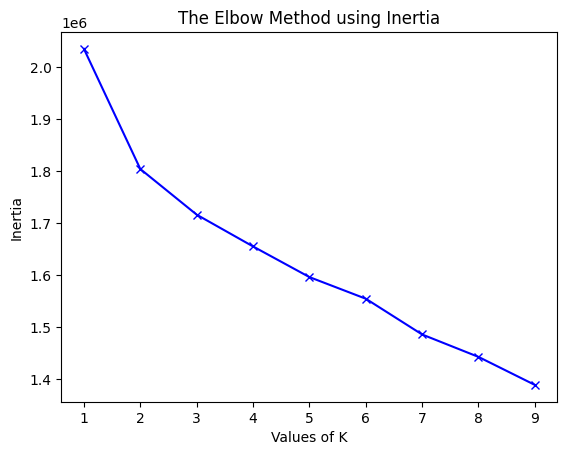

In [51]:
inertia = [] # empty list to store the inertia values for different values of K.   
range_val = range(1, 10)    # the range of K values to try

# Iterate each value of K
for i in range_val:
    kmeans = KMeans(n_clusters=i)    # Create a KMeans instance with current K value
    kmeans.fit_predict(pd.DataFrame(scaled_df))    # Fit the KMeans model on the scaled data
    inertia.append(kmeans.inertia_)    # Append the inertia value to the list

# Plotting the elbow curve
plt.plot(range_val, inertia, 'bx-')    # Plotting K values against inertia values
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

### Fit and Predict: 
- Train the K-means model with the optimal number of clusters and predict the cluster labels for each customer.

In [52]:
kmeans_model = KMeans(2)  # Create a KMeans instance with 4 clusters
kmeans_model.fit_predict(scaled_df)  # Fit the KMeans model to the scaled data and obtain cluster assignments
pca_df_kmeans = pd.concat([pca_df, pd.DataFrame({'cluster': kmeans_model.labels_})], axis=1)
# Combine the PCA components with the cluster labels

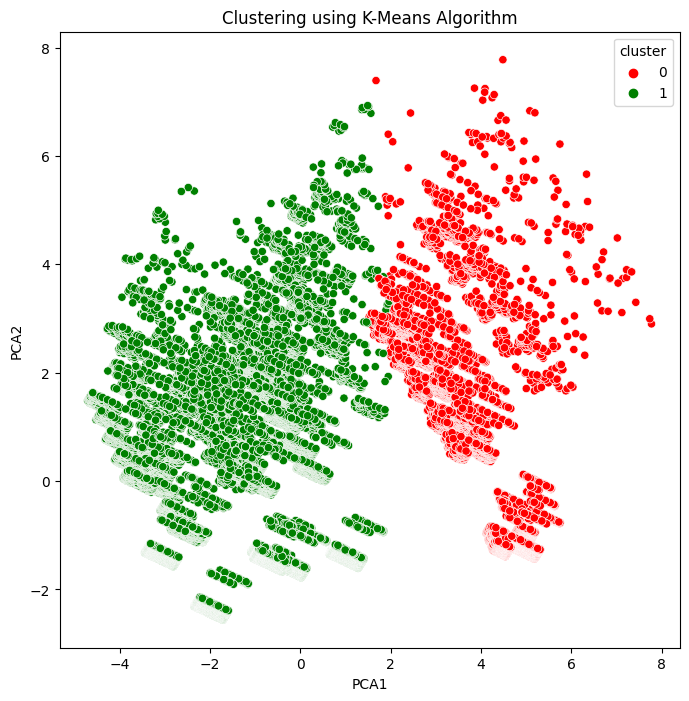

In [53]:
import seaborn as sns
plt.figure(figsize=(8, 8))  # Adjust plot size
# Scatter plot using PCA components and cluster labels
ax = sns.scatterplot(x="PCA1", y="PCA2", hue="cluster", data=pca_df_kmeans, palette=['red', 'green'])
plt.title("Clustering using K-Means Algorithm")
plt.show()

# Adding a new column "Cluster" for storing the cluster segment 
- Column "Cluster" could help us check the which cluster each row (Customer) belongs to.

In [54]:
# Concatenating the original DataFrame 'df' with cluster labels from "kmeans_model" with column name "Cluster"
cluster_df = pd.concat([df, pd.DataFrame({'Cluster': kmeans_model.labels_})], axis=1)
cluster_df

,transaction_id,price,quantity,age,tenure,return,Retail price,Cost,actual_price,profit,...,discount_0.0,discount_0.1,discount_0.15,discount_0.2,discount_0.25,discount_0.3,gender_F,gender_M,gender_Other,Cluster
0,1,59.99,1,22,2,0,59.99,34,59.99,25.99,...,1,0,0,0,0,0,1,0,0,1
1,2,56.99,1,22,2,0,56.99,35,56.99,21.99,...,1,0,0,0,0,0,1,0,0,1
2,3,44.99,2,22,2,0,44.99,20,40.49,20.49,...,0,1,0,0,0,0,1,0,0,1
3,4,79.99,1,22,2,0,79.99,48,59.99,11.99,...,0,0,0,0,1,0,1,0,0,1
4,5,69.99,1,22,2,0,69.99,42,69.99,27.99,...,1,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46260,46261,69.99,1,26,5,0,69.99,42,62.99,20.99,...,0,1,0,0,0,0,0,0,1,1
46261,46262,38.99,1,26,5,0,38.99,25,38.99,13.99,...,1,0,0,0,0,0,0,0,1,1
46262,46263,44.99,2,26,5,0,44.99,32,38.24,6.24,...,0,0,1,0,0,0,0,0,1,1
46263,46264,79.99,1,26,5,0,79.99,48,59.99,11.99,...,0,0,0,0,1,0,0,0,1,1


In [55]:
num_columns = cluster_df.shape[1]
print("Number of columns:", num_columns)

Number of columns: 45


# Visualization

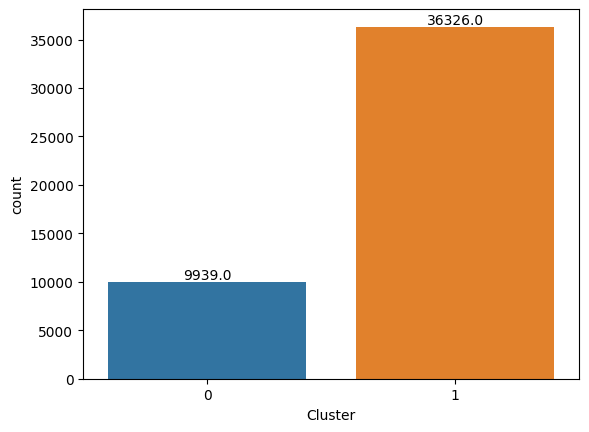

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
#uses the Seaborn library to create a countplot based on the 
# 'Cluster' column in the cluster_df DataFrame
ax= sns.countplot(x='Cluster', data=cluster_df)

# Add count labels to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.show()

In [57]:
#Saving Scikitlearn models
import joblib
joblib.dump(kmeans_model, "kmeans_model.pkl")

['kmeans_model.pkl']

# Train and Test the model accuracy using decision tree

In [58]:
X = cluster_df.drop(['Cluster'],axis=1)
y= cluster_df[['Cluster']]
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.3,random_state=3)

# Decision Tree Classifier

In [59]:
# Create a Decision Tree classifier with entropy as the criterion
model = DecisionTreeClassifier(criterion="entropy")

# Train the model 
model.fit(X_train, y_train)

# Use trained model to predict the labels for the testing data
y_pred = model.predict(X_test)

# Confusion Matrix

In [60]:
# Evaluate model performance by printing the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred))

# Print a classification report showing precision, recall, f1-score, and support
print(classification_report(y_test, y_pred))

[[ 3027     5]
 [    1 10847]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3032
           1       1.00      1.00      1.00     10848

    accuracy                           1.00     13880
   macro avg       1.00      1.00      1.00     13880
weighted avg       1.00      1.00      1.00     13880



# Further cross-validation

In [61]:
from sklearn.model_selection import cross_val_score

# Create a Decision Tree classifier with entropy as the criterion
model = DecisionTreeClassifier(criterion="entropy")

# Perform cross-validation with 5 folds
scores = cross_val_score(model, X, y, cv=5)

# Print the accuracy scores for each fold
print("Cross-validation scores:", scores)

# Print the average accuracy across all folds
print("Average accuracy:", scores.mean())

Cross-validation scores: [0.99989193 1.         0.99978385 0.99989193 0.99935156]
Average accuracy: 0.9997838538852264


# Obtain all cluster center points(centroids)
- Centroids are central point of each clusters which are most representative.We could take them as typical example to analyze their specific features.

In [62]:
cluster_centers = pd.DataFrame(data=kmeans_model.cluster_centers_,columns=[df.columns])
cluster_centers

,transaction_id,price,quantity,age,tenure,return,Retail price,Cost,actual_price,profit,...,sku_SCS72049,discount_0.0,discount_0.1,discount_0.15,discount_0.2,discount_0.25,discount_0.3,gender_F,gender_M,gender_Other
0,0.145508,1.658193,-0.007360,0.567926,0.469465,0.003384,1.658193,1.652128,1.569084,0.934600,...,-0.076315,0.045967,0.019667,0.014074,-0.023673,-0.051245,-0.032973,-0.265799,0.289984,-0.017144
1,-0.039812,-0.453691,0.002014,-0.155388,-0.128448,-0.000926,-0.453691,-0.452032,-0.429310,-0.255712,...,0.020880,-0.012577,-0.005381,-0.003851,0.006477,0.014021,0.009022,0.072724,-0.079341,0.004691


In [63]:
cluster_centers = scalar.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data=cluster_centers,columns=[df.columns])
cluster_centers

,transaction_id,price,quantity,age,tenure,return,Retail price,Cost,actual_price,profit,...,sku_SCS72049,discount_0.0,discount_0.1,discount_0.15,discount_0.2,discount_0.25,discount_0.3,gender_F,gender_M,gender_Other
0,25076.345709,98.031553,1.097797,29.801690,5.054834,0.058457,98.031553,60.424188,89.730215,29.306028,...,0.000302,0.579133,0.081900,0.084012,0.083208,0.084314,0.087433,0.792233,0.193782,0.013985
1,22601.289572,57.373279,1.100892,26.804851,2.944971,0.057452,57.373279,33.948384,51.803935,17.855551,...,0.008038,0.550047,0.075235,0.079144,0.091835,0.103865,0.099873,0.902659,0.080603,0.016737


In [64]:
import pandas as pd

# Set pandas' options to display values with 3 decimal places
pd.set_option('display.float_format', '{:.3f}'.format)

# First, transpose the DataFrame
cluster_centers_transposed = cluster_centers.transpose()

# Then, rename the columns to "Cluster 0", "Cluster 1", and so on
cluster_centers_transposed.columns = [f'Cluster {i}' for i in range(cluster_centers_transposed.shape[1])]

# Display the transposed DataFrame
print(cluster_centers_transposed)


                Cluster 0  Cluster 1
transaction_id  25076.346  22601.290
price              98.032     57.373
quantity            1.098      1.101
age                29.802     26.805
tenure              5.055      2.945
return              0.058      0.057
Retail price       98.032     57.373
Cost               60.424     33.948
actual_price       89.730     51.804
profit             29.306     17.856
total_profit       30.814     18.901
spend             107.455     63.346
sku_FCS48020       -0.000      0.007
sku_FCS48021       -0.000      0.104
sku_FCS48022        0.125      0.000
sku_FCS48023        0.122      0.000
sku_FCS48024       -0.000      0.046
sku_FCS48025        0.000      0.010
sku_FCS48026       -0.000      0.045
sku_FCS48027        0.125      0.000
sku_FCS48028        0.001      0.093
sku_FCS48029        0.000      0.110
sku_FCS48030        0.001      0.012
sku_FCS48031        0.000      0.093
sku_FCS48032       -0.000      0.047
sku_FCS48033        0.125      0.000
s

### Findings
- **Demographics:** The age for Cluster 0 is 29.802 years on average, while it's 26.805 years for Cluster 1. This indicates that customers in Cluster 0 are slightly older than those in Cluster 1.

- **Purchasing behavior:** The price and actual_price are higher for Cluster 0, meaning that customers in Cluster 0 tend to purchase more expensive items than those in Cluster 1. The quantity is similar for both clusters, indicating that the number of items per transaction is similar.

- **Engagement:** The tenure for Cluster 0 is higher, indicating that customers in this cluster have been with the company for a longer time compared to Cluster 1.

- **Product preferences:** The rows sku_FCS48020 through sku_SCS72049 represent different products or SKUs. The positive values in these rows indicate that the respective products are more popular among the customers in that cluster. For instance, sku_SCS72046 is more popular in Cluster 0, while sku_FCS48021 is more popular in Cluster 1.

- **Discounts:** The rows discount_0.0 through discount_0.3 represent the frequency of different discount levels among customers in the clusters. It seems that both clusters have a similar distribution of discount levels.

- **Gender:** The rows gender_F, gender_M, and gender_Other indicate the gender distribution of customers in the clusters. Cluster 0 has a higher proportion of male customers (gender_M), while Cluster 1 has a higher proportion of female customers (gender_F).

# Conclusion:

# Promotion Recomendation
### Approach 1: Targeting Current Customers
The target customers and offering products should be based on the goals of promotion campaign:
#### Goal 1 - Retaining customer getting churned and Increasing their spending: 
- Aim at customers with RFM score of 112 (profitable customers but did not purchase frequently for a while) and 122 (profitable and high frequent buyers but already left us for a while). 
- Send personalized coupon offers or discounts for their routine products or bundles to entice them to make a purchase.

#### Goal 2 - Up-selling and Cross-selling: 
- Focus on current customers who have lower "total spending" and "average price" compared to other customers in the portfolio.
- Use Market Basket Analysis (MBA) to identify products or bundles that are frequently purchased together by other customers.
- Utilize a recommender system to suggest alternative luxury lines of products or bundles based on the customer's past purchase history and the frequent itemsets identified through MBA.
- Send out personalized coupon offers for the recommended alternative products or bundles to encourage customers to try new and more luxurious options.

By using this approach, the promotion campaign can effectively target and engage existing customers with personalized offers tailored to their purchasing behavior and preferences. This strategy aims to retain customers, increase their spending, and encourage upselling and cross-selling, ultimately leading to higher customer satisfaction and increased revenue for the business.

### Approach 2: Reach out New Customers
The customer lifetime value analysis suggests that the company should focus on the 32-34 years old age group in the upcoming acquisition new customer campaign, as this cohort has the highest Customer Lifetime Value (CLV).

The company could implement the following strategies for the new customer campaign: send discount coupons offering promotions for the popular and basic bundles that were suggested by the Market Basket Analysis (MBA), such as SCS72048 and FCS48028, SCS72044 and SCS72043, SCS72046 and FCS48021.

By targeting new customers based on their potential value and utilizing the insights from the MBA and recommender system, the company can effectively attract and acquire new customers while maximizing their customer lifetime value.